# Loading Modules

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import imageio
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from what_where.main import init, MNIST
from what_where.what import WhatShift, WhatBackground, WhatNet
from stn import STN

# Loading the Data

- Loading the data with the parameters given in the .json file for the What/Where model

In [23]:
args = init(filename='what_where/2020-07-01')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

# Exploring the MNIST with the what noise parameters

- 28x28 pixel with shift and noise

In [24]:
transform=transforms.Compose([
                               WhatShift(args),
                               WhatBackground(contrast = args.contrast,
                                              noise=args.noise, 
                                              sf_0=args.sf_0, 
                                              B_sf=args.B_sf),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           #transforms.Normalize((0.4914,))
                           ])

dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        )

train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        )

test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [25]:
def view_dataset(loader: torch.utils.data.DataLoader, n: int=10) -> plt.Figure:
    
    data, label = next(iter(loader))
    fig, axs = plt.subplots(1, n, figsize = (21, 5))
    for i_ax, ax in enumerate(axs):
        ax.imshow(data[i_ax, 0, :, :], cmap=plt.gray())
        ax.set_title("Label = %d"%(label[i_ax].item()))
        ax.set_xticks([])
        ax.set_yticks([])
    return fig

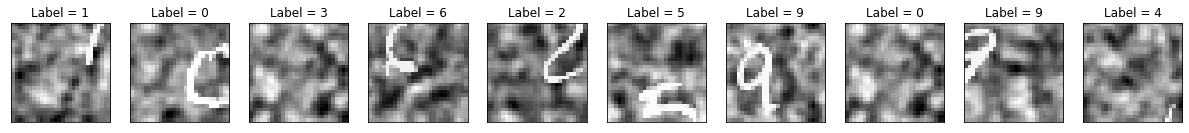

In [26]:
data = view_dataset(train_loader)
#data.savefig('../figures/noisy_no_shift_28x28_data.png')

# Spatial Transformer Network

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = STN().to(device)
#optimizer = optim.Adam(model.parameters(), lr=args.lr)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()#model = STN().to(device)
loss_vals=  []
acc_vals = []

In [27]:
def train(epoch, loader):

    epoch_loss= []
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, dtype=torch.float), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, args.epochs, batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), batch_loss))
        epoch_loss.append(batch_loss)
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))


def test(loader):

    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in loader:
            data, target = data.to(device,
                                   dtype=torch.float), target.to(device)
            output = model(data)
            test_loss += loss_func(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        
        acc = correct / len(test_loader.dataset)
        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset),
                     100. * acc))
        acc_vals.append(acc)

In [14]:
for ofst in range(15 + 1):

    args.what_offset_std = ofst
    print("Training on offset_std = %s" % (args.what_offset_std))
    transform = transforms.Compose([
        WhatShift(args),
        WhatBackground(contrast=args.contrast,
                       noise=args.noise,
                       sf_0=args.sf_0,
                       B_sf=args.B_sf),
        transforms.ToTensor(),
        #transforms.Normalize((args.mean,), (args.std,))
    ])

    train_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=True,
        download=True,
        transform=transform,
    ),
                                               batch_size=args.minibatch_size,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=False,
        download=True,
        transform=transform,
    ),
                                              batch_size=args.minibatch_size,
                                              shuffle=True)

    args.epochs = 20
    for epoch in range(1, args.epochs + 1):
        train(epoch, train_loader) 
        test(test_loader)
        #stn_grid(epoch)

Training on offset_std = 0
Train Epoch: 1/20 [0/60000 (0%)]	Loss: 2.301564
Train Epoch: 1/20 [10000/60000 (17%)]	Loss: 2.301821
Train Epoch: 1/20 [20000/60000 (33%)]	Loss: 2.295257
Train Epoch: 1/20 [30000/60000 (50%)]	Loss: 2.288388
Train Epoch: 1/20 [40000/60000 (67%)]	Loss: 2.287042
Train Epoch: 1/20 [50000/60000 (83%)]	Loss: 2.275207

Test set: Average loss: 0.0226, Accuracy: 3093/10000 (31%)

Train Epoch: 2/20 [0/60000 (0%)]	Loss: 2.275236
Train Epoch: 2/20 [10000/60000 (17%)]	Loss: 2.238195
Train Epoch: 2/20 [20000/60000 (33%)]	Loss: 2.188063
Train Epoch: 2/20 [30000/60000 (50%)]	Loss: 2.100445
Train Epoch: 2/20 [40000/60000 (67%)]	Loss: 1.827357
Train Epoch: 2/20 [50000/60000 (83%)]	Loss: 1.340720

Test set: Average loss: 0.0120, Accuracy: 6064/10000 (61%)

Train Epoch: 3/20 [0/60000 (0%)]	Loss: 1.340488
Train Epoch: 3/20 [10000/60000 (17%)]	Loss: 1.272444
Train Epoch: 3/20 [20000/60000 (33%)]	Loss: 1.079010
Train Epoch: 3/20 [30000/60000 (50%)]	Loss: 1.020007
Train Epoch: 3/20 

Train Epoch: 2/20 [50000/60000 (83%)]	Loss: 0.121147

Test set: Average loss: 0.0016, Accuracy: 9478/10000 (95%)

Train Epoch: 3/20 [0/60000 (0%)]	Loss: 0.211056
Train Epoch: 3/20 [10000/60000 (17%)]	Loss: 0.089908
Train Epoch: 3/20 [20000/60000 (33%)]	Loss: 0.199895
Train Epoch: 3/20 [30000/60000 (50%)]	Loss: 0.223756
Train Epoch: 3/20 [40000/60000 (67%)]	Loss: 0.113149
Train Epoch: 3/20 [50000/60000 (83%)]	Loss: 0.214218

Test set: Average loss: 0.0014, Accuracy: 9563/10000 (96%)

Train Epoch: 4/20 [0/60000 (0%)]	Loss: 0.096112
Train Epoch: 4/20 [10000/60000 (17%)]	Loss: 0.059263
Train Epoch: 4/20 [20000/60000 (33%)]	Loss: 0.131482
Train Epoch: 4/20 [30000/60000 (50%)]	Loss: 0.063505
Train Epoch: 4/20 [40000/60000 (67%)]	Loss: 0.104984
Train Epoch: 4/20 [50000/60000 (83%)]	Loss: 0.207071

Test set: Average loss: 0.0015, Accuracy: 9497/10000 (95%)

Train Epoch: 5/20 [0/60000 (0%)]	Loss: 0.149401
Train Epoch: 5/20 [10000/60000 (17%)]	Loss: 0.167713
Train Epoch: 5/20 [20000/60000 (33%)]

Train Epoch: 4/20 [30000/60000 (50%)]	Loss: 0.046947
Train Epoch: 4/20 [40000/60000 (67%)]	Loss: 0.137772
Train Epoch: 4/20 [50000/60000 (83%)]	Loss: 0.241129

Test set: Average loss: 0.0013, Accuracy: 9599/10000 (96%)

Train Epoch: 5/20 [0/60000 (0%)]	Loss: 0.135777
Train Epoch: 5/20 [10000/60000 (17%)]	Loss: 0.092521
Train Epoch: 5/20 [20000/60000 (33%)]	Loss: 0.187160
Train Epoch: 5/20 [30000/60000 (50%)]	Loss: 0.056697
Train Epoch: 5/20 [40000/60000 (67%)]	Loss: 0.154566
Train Epoch: 5/20 [50000/60000 (83%)]	Loss: 0.068988

Test set: Average loss: 0.0015, Accuracy: 9524/10000 (95%)

Train Epoch: 6/20 [0/60000 (0%)]	Loss: 0.227380
Train Epoch: 6/20 [10000/60000 (17%)]	Loss: 0.054003
Train Epoch: 6/20 [20000/60000 (33%)]	Loss: 0.117700
Train Epoch: 6/20 [30000/60000 (50%)]	Loss: 0.180451
Train Epoch: 6/20 [40000/60000 (67%)]	Loss: 0.125403
Train Epoch: 6/20 [50000/60000 (83%)]	Loss: 0.171331

Test set: Average loss: 0.0012, Accuracy: 9590/10000 (96%)

Train Epoch: 7/20 [0/60000 (0%)]

Train Epoch: 6/20 [10000/60000 (17%)]	Loss: 0.128089
Train Epoch: 6/20 [20000/60000 (33%)]	Loss: 0.098647
Train Epoch: 6/20 [30000/60000 (50%)]	Loss: 0.058171
Train Epoch: 6/20 [40000/60000 (67%)]	Loss: 0.098468
Train Epoch: 6/20 [50000/60000 (83%)]	Loss: 0.144978

Test set: Average loss: 0.0015, Accuracy: 9527/10000 (95%)

Train Epoch: 7/20 [0/60000 (0%)]	Loss: 0.137524
Train Epoch: 7/20 [10000/60000 (17%)]	Loss: 0.106012
Train Epoch: 7/20 [20000/60000 (33%)]	Loss: 0.179465
Train Epoch: 7/20 [30000/60000 (50%)]	Loss: 0.101916
Train Epoch: 7/20 [40000/60000 (67%)]	Loss: 0.114742
Train Epoch: 7/20 [50000/60000 (83%)]	Loss: 0.259512

Test set: Average loss: 0.0017, Accuracy: 9448/10000 (94%)

Train Epoch: 8/20 [0/60000 (0%)]	Loss: 0.256138
Train Epoch: 8/20 [10000/60000 (17%)]	Loss: 0.096897
Train Epoch: 8/20 [20000/60000 (33%)]	Loss: 0.067919
Train Epoch: 8/20 [30000/60000 (50%)]	Loss: 0.215535
Train Epoch: 8/20 [40000/60000 (67%)]	Loss: 0.220933
Train Epoch: 8/20 [50000/60000 (83%)]	Lo


Test set: Average loss: 0.0018, Accuracy: 9439/10000 (94%)

Train Epoch: 8/20 [0/60000 (0%)]	Loss: 0.269723
Train Epoch: 8/20 [10000/60000 (17%)]	Loss: 0.092534
Train Epoch: 8/20 [20000/60000 (33%)]	Loss: 0.300711
Train Epoch: 8/20 [30000/60000 (50%)]	Loss: 0.253652
Train Epoch: 8/20 [40000/60000 (67%)]	Loss: 0.164607
Train Epoch: 8/20 [50000/60000 (83%)]	Loss: 0.292578

Test set: Average loss: 0.0017, Accuracy: 9455/10000 (95%)

Train Epoch: 9/20 [0/60000 (0%)]	Loss: 0.184680
Train Epoch: 9/20 [10000/60000 (17%)]	Loss: 0.099491
Train Epoch: 9/20 [20000/60000 (33%)]	Loss: 0.175498
Train Epoch: 9/20 [30000/60000 (50%)]	Loss: 0.148445
Train Epoch: 9/20 [40000/60000 (67%)]	Loss: 0.107281
Train Epoch: 9/20 [50000/60000 (83%)]	Loss: 0.087481

Test set: Average loss: 0.0017, Accuracy: 9483/10000 (95%)

Train Epoch: 10/20 [0/60000 (0%)]	Loss: 0.064741
Train Epoch: 10/20 [10000/60000 (17%)]	Loss: 0.151733
Train Epoch: 10/20 [20000/60000 (33%)]	Loss: 0.167744
Train Epoch: 10/20 [30000/60000 (5

Train Epoch: 9/20 [40000/60000 (67%)]	Loss: 0.448788
Train Epoch: 9/20 [50000/60000 (83%)]	Loss: 0.375419

Test set: Average loss: 0.0025, Accuracy: 9209/10000 (92%)

Train Epoch: 10/20 [0/60000 (0%)]	Loss: 0.265574
Train Epoch: 10/20 [10000/60000 (17%)]	Loss: 0.124852
Train Epoch: 10/20 [20000/60000 (33%)]	Loss: 0.255133
Train Epoch: 10/20 [30000/60000 (50%)]	Loss: 0.167106
Train Epoch: 10/20 [40000/60000 (67%)]	Loss: 0.123470
Train Epoch: 10/20 [50000/60000 (83%)]	Loss: 0.228243

Test set: Average loss: 0.0021, Accuracy: 9323/10000 (93%)

Train Epoch: 11/20 [0/60000 (0%)]	Loss: 0.230088
Train Epoch: 11/20 [10000/60000 (17%)]	Loss: 0.147453
Train Epoch: 11/20 [20000/60000 (33%)]	Loss: 0.139415
Train Epoch: 11/20 [30000/60000 (50%)]	Loss: 0.220513
Train Epoch: 11/20 [40000/60000 (67%)]	Loss: 0.191851
Train Epoch: 11/20 [50000/60000 (83%)]	Loss: 0.176759

Test set: Average loss: 0.0027, Accuracy: 9158/10000 (92%)

Train Epoch: 12/20 [0/60000 (0%)]	Loss: 0.239431
Train Epoch: 12/20 [1000

Train Epoch: 11/20 [20000/60000 (33%)]	Loss: 0.262537
Train Epoch: 11/20 [30000/60000 (50%)]	Loss: 0.262222
Train Epoch: 11/20 [40000/60000 (67%)]	Loss: 0.244906
Train Epoch: 11/20 [50000/60000 (83%)]	Loss: 0.258593

Test set: Average loss: 0.0030, Accuracy: 9012/10000 (90%)

Train Epoch: 12/20 [0/60000 (0%)]	Loss: 0.298119
Train Epoch: 12/20 [10000/60000 (17%)]	Loss: 0.300799
Train Epoch: 12/20 [20000/60000 (33%)]	Loss: 0.355070
Train Epoch: 12/20 [30000/60000 (50%)]	Loss: 0.229804
Train Epoch: 12/20 [40000/60000 (67%)]	Loss: 0.229236
Train Epoch: 12/20 [50000/60000 (83%)]	Loss: 0.212763

Test set: Average loss: 0.0029, Accuracy: 9052/10000 (91%)

Train Epoch: 13/20 [0/60000 (0%)]	Loss: 0.328215
Train Epoch: 13/20 [10000/60000 (17%)]	Loss: 0.254899
Train Epoch: 13/20 [20000/60000 (33%)]	Loss: 0.205881
Train Epoch: 13/20 [30000/60000 (50%)]	Loss: 0.297645
Train Epoch: 13/20 [40000/60000 (67%)]	Loss: 0.224979
Train Epoch: 13/20 [50000/60000 (83%)]	Loss: 0.312688

Test set: Average loss:

Train Epoch: 13/20 [10000/60000 (17%)]	Loss: 0.459042
Train Epoch: 13/20 [20000/60000 (33%)]	Loss: 0.794499
Train Epoch: 13/20 [30000/60000 (50%)]	Loss: 0.427405
Train Epoch: 13/20 [40000/60000 (67%)]	Loss: 0.281270
Train Epoch: 13/20 [50000/60000 (83%)]	Loss: 0.275181

Test set: Average loss: 0.0040, Accuracy: 8656/10000 (87%)

Train Epoch: 14/20 [0/60000 (0%)]	Loss: 0.327808
Train Epoch: 14/20 [10000/60000 (17%)]	Loss: 0.401660
Train Epoch: 14/20 [20000/60000 (33%)]	Loss: 0.218914
Train Epoch: 14/20 [30000/60000 (50%)]	Loss: 0.274541
Train Epoch: 14/20 [40000/60000 (67%)]	Loss: 0.286847
Train Epoch: 14/20 [50000/60000 (83%)]	Loss: 0.346486

Test set: Average loss: 0.0039, Accuracy: 8680/10000 (87%)

Train Epoch: 15/20 [0/60000 (0%)]	Loss: 0.511292
Train Epoch: 15/20 [10000/60000 (17%)]	Loss: 0.421459
Train Epoch: 15/20 [20000/60000 (33%)]	Loss: 0.417946
Train Epoch: 15/20 [30000/60000 (50%)]	Loss: 0.378194
Train Epoch: 15/20 [40000/60000 (67%)]	Loss: 0.291232
Train Epoch: 15/20 [5000


Test set: Average loss: 0.0047, Accuracy: 8362/10000 (84%)

Train Epoch: 15/20 [0/60000 (0%)]	Loss: 0.476812
Train Epoch: 15/20 [10000/60000 (17%)]	Loss: 0.314244
Train Epoch: 15/20 [20000/60000 (33%)]	Loss: 0.377867
Train Epoch: 15/20 [30000/60000 (50%)]	Loss: 0.482441
Train Epoch: 15/20 [40000/60000 (67%)]	Loss: 0.427791
Train Epoch: 15/20 [50000/60000 (83%)]	Loss: 0.352145

Test set: Average loss: 0.0047, Accuracy: 8385/10000 (84%)

Train Epoch: 16/20 [0/60000 (0%)]	Loss: 0.513845
Train Epoch: 16/20 [10000/60000 (17%)]	Loss: 0.261480
Train Epoch: 16/20 [20000/60000 (33%)]	Loss: 0.487962
Train Epoch: 16/20 [30000/60000 (50%)]	Loss: 0.475769
Train Epoch: 16/20 [40000/60000 (67%)]	Loss: 0.424713
Train Epoch: 16/20 [50000/60000 (83%)]	Loss: 0.548000

Test set: Average loss: 0.0048, Accuracy: 8340/10000 (83%)

Train Epoch: 17/20 [0/60000 (0%)]	Loss: 0.566744
Train Epoch: 17/20 [10000/60000 (17%)]	Loss: 0.459514
Train Epoch: 17/20 [20000/60000 (33%)]	Loss: 0.564804
Train Epoch: 17/20 [30

Train Epoch: 16/20 [40000/60000 (67%)]	Loss: 0.560799
Train Epoch: 16/20 [50000/60000 (83%)]	Loss: 0.761622

Test set: Average loss: 0.0059, Accuracy: 7939/10000 (79%)

Train Epoch: 17/20 [0/60000 (0%)]	Loss: 0.464750
Train Epoch: 17/20 [10000/60000 (17%)]	Loss: 0.486636
Train Epoch: 17/20 [20000/60000 (33%)]	Loss: 0.483197
Train Epoch: 17/20 [30000/60000 (50%)]	Loss: 0.544355
Train Epoch: 17/20 [40000/60000 (67%)]	Loss: 0.567734
Train Epoch: 17/20 [50000/60000 (83%)]	Loss: 0.547845

Test set: Average loss: 0.0060, Accuracy: 7923/10000 (79%)

Train Epoch: 18/20 [0/60000 (0%)]	Loss: 0.458128
Train Epoch: 18/20 [10000/60000 (17%)]	Loss: 0.422192
Train Epoch: 18/20 [20000/60000 (33%)]	Loss: 0.506349
Train Epoch: 18/20 [30000/60000 (50%)]	Loss: 0.795909
Train Epoch: 18/20 [40000/60000 (67%)]	Loss: 0.620949
Train Epoch: 18/20 [50000/60000 (83%)]	Loss: 0.765837

Test set: Average loss: 0.0060, Accuracy: 7880/10000 (79%)

Train Epoch: 19/20 [0/60000 (0%)]	Loss: 0.545045
Train Epoch: 19/20 [10

Train Epoch: 18/20 [20000/60000 (33%)]	Loss: 0.659015
Train Epoch: 18/20 [30000/60000 (50%)]	Loss: 0.891503
Train Epoch: 18/20 [40000/60000 (67%)]	Loss: 0.668302
Train Epoch: 18/20 [50000/60000 (83%)]	Loss: 0.600756

Test set: Average loss: 0.0072, Accuracy: 7409/10000 (74%)

Train Epoch: 19/20 [0/60000 (0%)]	Loss: 0.518190
Train Epoch: 19/20 [10000/60000 (17%)]	Loss: 0.744788
Train Epoch: 19/20 [20000/60000 (33%)]	Loss: 0.784824
Train Epoch: 19/20 [30000/60000 (50%)]	Loss: 0.882123
Train Epoch: 19/20 [40000/60000 (67%)]	Loss: 0.656532
Train Epoch: 19/20 [50000/60000 (83%)]	Loss: 0.652675

Test set: Average loss: 0.0074, Accuracy: 7345/10000 (73%)

Train Epoch: 20/20 [0/60000 (0%)]	Loss: 0.841133
Train Epoch: 20/20 [10000/60000 (17%)]	Loss: 0.768992
Train Epoch: 20/20 [20000/60000 (33%)]	Loss: 0.528756
Train Epoch: 20/20 [30000/60000 (50%)]	Loss: 0.742174
Train Epoch: 20/20 [40000/60000 (67%)]	Loss: 0.778746
Train Epoch: 20/20 [50000/60000 (83%)]	Loss: 0.815610

Test set: Average loss:

Train Epoch: 20/20 [10000/60000 (17%)]	Loss: 0.724990
Train Epoch: 20/20 [20000/60000 (33%)]	Loss: 0.653554
Train Epoch: 20/20 [30000/60000 (50%)]	Loss: 0.678906
Train Epoch: 20/20 [40000/60000 (67%)]	Loss: 0.830141
Train Epoch: 20/20 [50000/60000 (83%)]	Loss: 0.969266

Test set: Average loss: 0.0083, Accuracy: 6971/10000 (70%)

Training on offset_std = 12
Train Epoch: 1/20 [0/60000 (0%)]	Loss: 0.778030
Train Epoch: 1/20 [10000/60000 (17%)]	Loss: 1.086391
Train Epoch: 1/20 [20000/60000 (33%)]	Loss: 0.934902
Train Epoch: 1/20 [30000/60000 (50%)]	Loss: 0.901669
Train Epoch: 1/20 [40000/60000 (67%)]	Loss: 0.962640
Train Epoch: 1/20 [50000/60000 (83%)]	Loss: 1.227640

Test set: Average loss: 0.0101, Accuracy: 6357/10000 (64%)

Train Epoch: 2/20 [0/60000 (0%)]	Loss: 1.025842
Train Epoch: 2/20 [10000/60000 (17%)]	Loss: 1.041632
Train Epoch: 2/20 [20000/60000 (33%)]	Loss: 0.968794
Train Epoch: 2/20 [30000/60000 (50%)]	Loss: 0.784766
Train Epoch: 2/20 [40000/60000 (67%)]	Loss: 0.814279
Train E

Train Epoch: 1/20 [50000/60000 (83%)]	Loss: 1.126816

Test set: Average loss: 0.0106, Accuracy: 6061/10000 (61%)

Train Epoch: 2/20 [0/60000 (0%)]	Loss: 0.998577
Train Epoch: 2/20 [10000/60000 (17%)]	Loss: 1.148548
Train Epoch: 2/20 [20000/60000 (33%)]	Loss: 1.145619
Train Epoch: 2/20 [30000/60000 (50%)]	Loss: 1.193216
Train Epoch: 2/20 [40000/60000 (67%)]	Loss: 1.260584
Train Epoch: 2/20 [50000/60000 (83%)]	Loss: 1.076082

Test set: Average loss: 0.0107, Accuracy: 6003/10000 (60%)

Train Epoch: 3/20 [0/60000 (0%)]	Loss: 1.207011
Train Epoch: 3/20 [10000/60000 (17%)]	Loss: 0.970871
Train Epoch: 3/20 [20000/60000 (33%)]	Loss: 1.064354
Train Epoch: 3/20 [30000/60000 (50%)]	Loss: 1.311860
Train Epoch: 3/20 [40000/60000 (67%)]	Loss: 1.100274
Train Epoch: 3/20 [50000/60000 (83%)]	Loss: 1.372355

Test set: Average loss: 0.0109, Accuracy: 5987/10000 (60%)

Train Epoch: 4/20 [0/60000 (0%)]	Loss: 1.105089
Train Epoch: 4/20 [10000/60000 (17%)]	Loss: 0.945784
Train Epoch: 4/20 [20000/60000 (33%)]

Train Epoch: 3/20 [30000/60000 (50%)]	Loss: 1.136672
Train Epoch: 3/20 [40000/60000 (67%)]	Loss: 1.230954
Train Epoch: 3/20 [50000/60000 (83%)]	Loss: 1.304107

Test set: Average loss: 0.0120, Accuracy: 5560/10000 (56%)

Train Epoch: 4/20 [0/60000 (0%)]	Loss: 1.132296
Train Epoch: 4/20 [10000/60000 (17%)]	Loss: 0.993412
Train Epoch: 4/20 [20000/60000 (33%)]	Loss: 1.153243
Train Epoch: 4/20 [30000/60000 (50%)]	Loss: 1.108344
Train Epoch: 4/20 [40000/60000 (67%)]	Loss: 1.112004
Train Epoch: 4/20 [50000/60000 (83%)]	Loss: 1.281973

Test set: Average loss: 0.0133, Accuracy: 5080/10000 (51%)

Train Epoch: 5/20 [0/60000 (0%)]	Loss: 1.321393
Train Epoch: 5/20 [10000/60000 (17%)]	Loss: 1.253626
Train Epoch: 5/20 [20000/60000 (33%)]	Loss: 1.324654
Train Epoch: 5/20 [30000/60000 (50%)]	Loss: 1.173983
Train Epoch: 5/20 [40000/60000 (67%)]	Loss: 1.208097
Train Epoch: 5/20 [50000/60000 (83%)]	Loss: 1.196138

Test set: Average loss: 0.0126, Accuracy: 5347/10000 (53%)

Train Epoch: 6/20 [0/60000 (0%)]

Train Epoch: 5/20 [10000/60000 (17%)]	Loss: 1.442459
Train Epoch: 5/20 [20000/60000 (33%)]	Loss: 1.378261
Train Epoch: 5/20 [30000/60000 (50%)]	Loss: 1.515598
Train Epoch: 5/20 [40000/60000 (67%)]	Loss: 1.197315
Train Epoch: 5/20 [50000/60000 (83%)]	Loss: 1.056522

Test set: Average loss: 0.0132, Accuracy: 5095/10000 (51%)

Train Epoch: 6/20 [0/60000 (0%)]	Loss: 1.422606
Train Epoch: 6/20 [10000/60000 (17%)]	Loss: 1.213313
Train Epoch: 6/20 [20000/60000 (33%)]	Loss: 1.590998
Train Epoch: 6/20 [30000/60000 (50%)]	Loss: 1.361583
Train Epoch: 6/20 [40000/60000 (67%)]	Loss: 1.370983
Train Epoch: 6/20 [50000/60000 (83%)]	Loss: 1.374701

Test set: Average loss: 0.0133, Accuracy: 5114/10000 (51%)

Train Epoch: 7/20 [0/60000 (0%)]	Loss: 1.379676
Train Epoch: 7/20 [10000/60000 (17%)]	Loss: 1.217147
Train Epoch: 7/20 [20000/60000 (33%)]	Loss: 1.391237
Train Epoch: 7/20 [30000/60000 (50%)]	Loss: 1.374841
Train Epoch: 7/20 [40000/60000 (67%)]	Loss: 1.308931
Train Epoch: 7/20 [50000/60000 (83%)]	Lo

In [33]:
args.what_offset_std = 5
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    return inp

thetas = []
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0][:64, :, :, :].to(device) # taking only a batch of 64 for a better plot

        input_tensor = data.cpu()
        
        output_tensor, theta = model.transformer_module.stn(data)
        thetas.append(theta)
        
        transformed_input_tensor = output_tensor.cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2, dpi=300)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        axarr[0].set_xticks([])
        axarr[0].set_yticks([])

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')
        axarr[1].set_xticks([])
        axarr[1].set_yticks([])
        #f.savefig('../figures/results_trained.png')

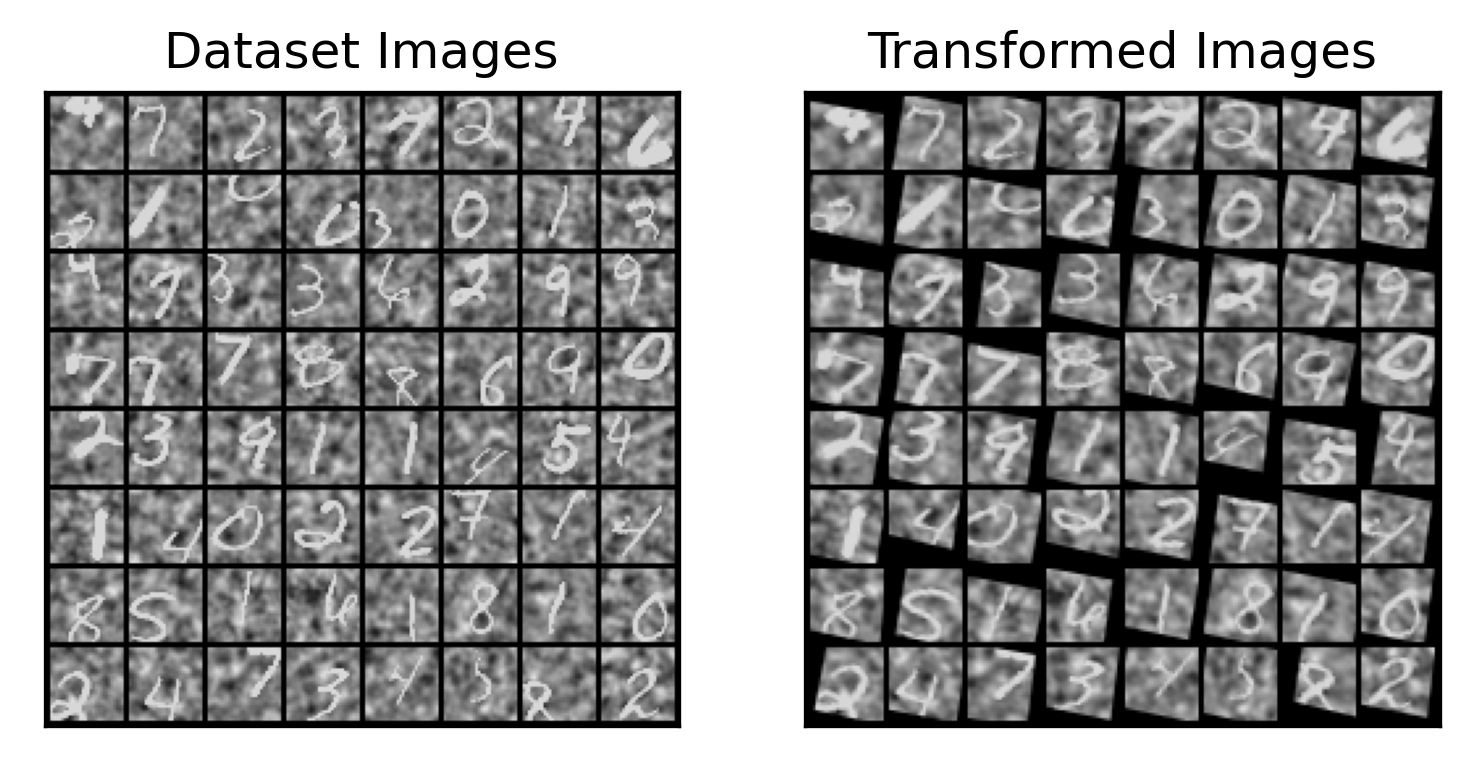

In [34]:
visualize_stn()

In [35]:
thetas

[tensor([[[ 8.1528e-01,  1.7777e-01, -4.1781e-02],
          [-1.6776e-01,  9.1951e-01, -3.6948e-01]],
 
         [[ 8.4847e-01,  1.3980e-01, -3.7189e-01],
          [-1.8110e-01,  9.4288e-01, -1.0517e-01]],
 
         [[ 8.8204e-01,  1.1695e-01,  1.7889e-01],
          [-1.9009e-01,  9.7216e-01, -2.2977e-02]],
 
         [[ 8.5378e-01,  1.6344e-01,  2.2051e-01],
          [-1.8291e-01,  9.4269e-01, -2.6220e-02]],
 
         [[ 8.1867e-01,  1.3113e-01,  1.9103e-01],
          [-1.7272e-01,  8.8324e-01,  9.1610e-02]],
 
         [[ 8.4684e-01,  1.0206e-01, -9.0270e-02],
          [-1.7944e-01,  9.5409e-01, -1.4018e-01]],
 
         [[ 8.6310e-01,  1.5421e-01,  9.1365e-02],
          [-1.7538e-01,  9.6993e-01, -2.3909e-01]],
 
         [[ 9.0937e-01,  9.6485e-02,  2.0267e-01],
          [-1.8996e-01,  9.5593e-01,  2.3773e-01]],
 
         [[ 9.3475e-01,  1.2288e-01, -9.0332e-04],
          [-2.0632e-01,  9.1634e-01,  3.6499e-01]],
 
         [[ 8.2896e-01,  1.4483e-01, -4.0581e-01],
    

# Saving the model

In [21]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = "../models/stn_28x28_shift_dependant_sgd.pt"
#torch.save(model, PATH)

# General accuracy

In [28]:
model = torch.load(PATH).to(device)
#optimizer = optim.Adam(model.parameters(), lr=args.lr)
#loss_func = nn.CrossEntropyLoss()

In [29]:
args.what_offset_std

15

In [30]:
test(test_loader)


Test set: Average loss: 0.0131, Accuracy: 5134/10000 (51%)



# Central accuracy

In [31]:
args.what_offset_std = 0
test_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

In [32]:
test(test_loader)


Test set: Average loss: 0.0012, Accuracy: 9644/10000 (96%)



# Loss and accuracy over epochs

In [71]:
acc_vals = [
    0.3093, 0.6064, 0.7432, 0.8021, 0.8583, 0.8845, 0.9075, 0.9219, 0.9333,
    0.937, 0.9444, 0.9451, 0.95, 0.9486, 0.9542, 0.9496, 0.959, 0.9592, 0.962,
    0.9603, 0.9506, 0.9478, 0.9563, 0.9497, 0.9621, 0.9599, 0.9644, 0.9636,
    0.9585, 0.9655, 0.9663, 0.9633, 0.9652, 0.9664, 0.9672, 0.9688, 0.9666,
    0.9691, 0.9686, 0.97, 0.9505, 0.9518, 0.9558, 0.9599, 0.9524, 0.959,
    0.9581, 0.962, 0.955, 0.9634, 0.9654, 0.9571, 0.9649, 0.9624, 0.965,
    0.9647, 0.9642, 0.9687, 0.9653, 0.9664, 0.9477, 0.9403, 0.9477, 0.9455,
    0.9507, 0.9527, 0.9448, 0.948, 0.9577, 0.9569, 0.9555, 0.9605, 0.9615,
    0.9568, 0.9607, 0.9522, 0.9598, 0.9514, 0.9625, 0.9611, 0.9327, 0.9195,
    0.9368, 0.942, 0.9444, 0.9424, 0.9439, 0.9455, 0.9483, 0.9488, 0.9512,
    0.9421, 0.9415, 0.9474, 0.9347, 0.9551, 0.9472, 0.9512, 0.9545, 0.9553,
    0.9222, 0.917, 0.9219, 0.9265, 0.9238, 0.9307, 0.9314, 0.9319, 0.9209,
    0.9323, 0.9158, 0.9219, 0.9308, 0.9348, 0.935, 0.9301, 0.9322, 0.9249,
    0.9287, 0.9358, 0.8971, 0.8923, 0.8993, 0.9009, 0.9023, 0.9025, 0.9052,
    0.8909, 0.8906, 0.9, 0.9012, 0.9052, 0.9085, 0.8967, 0.9041, 0.8978,
    0.9113, 0.91, 0.9081, 0.9097, 0.8684, 0.8682, 0.8697, 0.866, 0.8709,
    0.8728, 0.874, 0.875, 0.8738, 0.8797, 0.8692, 0.8686, 0.8656, 0.868,
    0.7876, 0.8718, 0.8801, 0.8831, 0.8737, 0.8806, 0.8215, 0.8338, 0.8052,
    0.8261, 0.8244, 0.8201, 0.8346, 0.8153, 0.8349, 0.834, 0.8331, 0.8161,
    0.8205, 0.8362, 0.8385, 0.834, 0.8304, 0.834, 0.8355, 0.8006, 0.7811,
    0.7837, 0.7777, 0.7983, 0.7792, 0.7724, 0.79, 0.7638, 0.7922, 0.7905,
    0.7783, 0.7957, 0.7866, 0.7971, 0.7948, 0.7939, 0.7923, 0.788, 0.7988,
    0.8003, 0.7363, 0.7386, 0.744, 0.7198, 0.7241, 0.7278, 0.738, 0.742,
    0.7327, 0.7394, 0.7367, 0.7522, 0.7469, 0.7428, 0.7321, 0.741, 0.7424,
    0.7409, 0.7345, 0.6945, 0.698, 0.684, 0.6984, 0.6945, 0.6925, 0.7026,
    0.6688, 0.6958, 0.6711, 0.6992, 0.7047, 0.7018, 0.6944, 0.6847, 0.6602,
    0.6886, 0.6884, 0.6953, 0.6965, 0.6971, 0.6357, 0.6467, 0.6381, 0.6521,
    0.6402, 0.6488, 0.6165, 0.6395, 0.6449, 0.6415, 0.6535, 0.6518, 0.6367,
    0.6291, 0.6515, 0.6497, 0.6391, 0.6516, 0.6444, 0.6428, 0.6061, 0.6003,
    0.5987, 0.6019, 0.6122, 0.6077, 0.5956, 0.591, 0.6095, 0.585, 0.6116,
    0.5949, 0.5907, 0.6003, 0.6018, 0.6103, 0.6029, 0.6142, 0.6059, 0.6059,
    0.5517, 0.5482, 0.556, 0.508, 0.5347, 0.5445, 0.5571, 0.5501, 0.5664,
    0.5662, 0.5287, 0.5548, 0.5552, 0.5507, 0.5554, 0.5531, 0.5655, 0.5445,
    0.5625, 0.5712, 0.5277, 0.522, 0.5318, 0.5182, 0.5095, 0.5114, 0.5181,
    0.5212, 0.5283, 0.5147, 0.5272, 0.5294, 0.4962, 0.5075, 0.5266, 0.5297,
    0.5301, 0.5324, 0.5336, 0.5134
]

loss_vals = [
    2.286695384979248, 1.9285496163368225, 0.9803406612078349,
    0.745513089299202, 0.5689755832652251, 0.43876292002697787,
    0.35076369387408096, 0.2929309501250585, 0.2590188171466192,
    0.22812861517071725, 0.20769931059951582, 0.18959866668408115,
    0.17777793399368724, 0.16447451944152514, 0.15243016785010696,
    0.14431485838877658, 0.13716018924800058, 0.12999546478812893,
    0.12476990952156485, 0.11937916751950979, 0.1933037592843175,
    0.17068537377441922, 0.15579542001709343, 0.14656712089975674,
    0.13938486704602837, 0.1326268125884235, 0.1281212023148934,
    0.12241021792093913, 0.11847146552987396, 0.1136555099238952,
    0.10872118018257121, 0.10586627492681146, 0.10156805622701844,
    0.09925980080539981, 0.09659668372943997, 0.09322806113399565,
    0.09103941322304308, 0.0887959790059055, 0.08655453649970392,
    0.08500339422064523, 0.22546676762402057, 0.18375772616515557,
    0.16663298008963465, 0.15446368709827463, 0.1441217488485078,
    0.1393447108628849, 0.1314802111250659, 0.12679938457285364,
    0.12032857798039913, 0.11840867701917887, 0.11364443689274291,
    0.10952643277123571, 0.10648028215393424, 0.10479494313088557,
    0.10366520506640275, 0.09893041216457883, 0.09546529076683025,
    0.09310287557542324, 0.09238427723447482, 0.08902628708009919,
    0.2160568372098108, 0.19054939072579147, 0.17766483038663863,
    0.16786772625520827, 0.15788700584322213, 0.1528766418931385,
    0.14886249623882275, 0.14322721971198915, 0.1354873503589382,
    0.13503083048698802, 0.1307588328110675, 0.12424280357236664,
    0.1228119407594204, 0.12224273975628118, 0.11680992547112207,
    0.11177853544553121, 0.11201810665739079, 0.10823331524307529,
    0.10595688848135372, 0.10180886659150322, 0.24691160878787438,
    0.22476880957062045, 0.2100762023528417, 0.2006059321636955,
    0.1896305793710053, 0.1821620026603341, 0.17447087882707515,
    0.1726596702883641, 0.1682114413504799, 0.16406465136756498,
    0.1570504580810666, 0.15378655940294267, 0.1510779425005118,
    0.15169221791128318, 0.1437487336496512, 0.14097067082921663,
    0.1386356999973456, 0.13607812485968074, 0.13192553758621217,
    0.1310085434342424, 0.2978735227882862, 0.27207673008243244,
    0.2598241294672092, 0.24846215926110746, 0.24569567184895277,
    0.23863548927009107, 0.22904819707075755, 0.2239153764521082,
    0.22296353539451957, 0.21244219480703275, 0.21065229516476391,
    0.20989365650340916, 0.20612819800153376, 0.2015946024345855,
    0.19760200964907806, 0.196468978288273, 0.1932240015330414,
    0.18858338555321097, 0.18572590930387378, 0.18438673769434294,
    0.35575153614083926, 0.3358966539551814, 0.3288193461547295,
    0.32047019315262637, 0.3135875387365619, 0.30711392803738513,
    0.29791504292438425, 0.2918439736093084, 0.2893299739435315,
    0.28481388056029877, 0.2820868552600344, 0.27932813188682,
    0.27574617192149165, 0.26881649900227783, 0.26839898224920034,
    0.2658214924360315, 0.2596364329382777, 0.2586798575396339,
    0.25193959758927426, 0.2556170127292474, 0.4307006043444077,
    0.4202891017993291, 0.41588859535753725, 0.40387813416620094,
    0.39583280617992084, 0.3930962899327278, 0.3824352244287729,
    0.3770197179168463, 0.3846123411009709, 0.3719363014648358,
    0.37053963748117286, 0.3678762797266245, 0.3655950601398945,
    0.3598873085528612, 0.3554203415537874, 0.3591125489274661,
    0.35298085771501064, 0.35008618772029876, 0.34954101987183095,
    0.34541631132364276, 0.5234539111206928, 0.5163691710432371,
    0.5160775946080685, 0.5027624617268642, 0.4908181332796812,
    0.4958469774325689, 0.4881361757715543, 0.4843935344616572,
    0.477956637814641, 0.47738929994404317, 0.47127946140865484,
    0.4718810979773601, 0.4719842283924421, 0.4640361305574576,
    0.45980036824941634, 0.4616509608924389, 0.45768639236688613,
    0.4624459555496772, 0.4551541845748822, 0.4516192486633857,
    0.6139048218230406, 0.6220993551115195, 0.6118884279330572,
    0.6046777120232583, 0.6095265379548073, 0.6033446672062079,
    0.6124149546523889, 0.5892090325057506, 0.5929870191713175,
    0.5921253895759583, 0.5963891543447971, 0.5904057603577773,
    0.5835660214225451, 0.5844400891661644, 0.5739727887511253,
    0.5772351922591528, 0.5787807287772496, 0.5759148430327574,
    0.5733624572058519, 0.5674678403139114, 0.7553241026401519,
    0.7421118717392285, 0.7475462715824445, 0.7388891068100929,
    0.7408417441447576, 0.769106551806132, 0.7311865701774756,
    0.7242196774482728, 0.7666522787014644, 0.7422886611521244,
    0.7244569199283918, 0.7236938532193502, 0.7111980231106281,
    0.718111130297184, 0.7178975682953993, 0.712137325356404,
    0.7181961663564046, 0.7066147999465465, 0.7072034937640032,
    0.7130676250159741, 0.8674844770630201, 0.8823193867007891,
    0.8844042292237282, 0.8753126659989356, 0.8721135026216507,
    0.8661978072921435, 0.8740030404925346, 0.8768836892644565,
    0.8488577221830685, 0.8548908252517382, 0.8417306855320931,
    0.8475080093741417, 0.8410031847159067, 0.8828844847281774,
    0.868436139523983, 0.881979860564073, 0.8793178100387256,
    0.8896087979276975, 0.862629847129186, 0.8603416470686595,
    1.02165524293979, 1.0149027891953786, 1.0094989584883054,
    0.995038837591807, 0.9993878131111463, 0.9925770997007688,
    1.043540836572647, 1.0064747205376625, 1.0031440299749375,
    0.9978899947802226, 0.9844500535726547, 0.9740093754728635,
    0.9879735951622327, 0.9796195588509242, 0.9716059464216232,
    0.9762406689922015, 0.9729333525896072, 0.9723653238018354,
    0.9738521195451418, 0.9819302442669868, 1.1039063394069673,
    1.1103720182180405, 1.1036788804332416, 1.1277095525463423,
    1.0933899709582329, 1.1026366103688876, 1.091551740070184,
    1.123860065639019, 1.0950069146354993, 1.094362051387628,
    1.0962022335330646, 1.0936318296194076, 1.1003111312786737,
    1.0851193746924401, 1.082588951488336, 1.0809541935722033,
    1.0732222534219424, 1.0810605435570082, 1.069176395336787,
    1.0600498907764753, 1.1886918221910794, 1.196295546591282,
    1.201578629811605, 1.1998108300566672, 1.1970104400316874,
    1.217775708635648, 1.2122839585940044, 1.1994305756688117,
    1.1733051828543346, 1.187388720413049, 1.2037185128529866,
    1.1960027622183165, 1.182484478553136, 1.1826710498332977,
    1.196703052620093, 1.1977760037779808, 1.1894154320160548, 1.1797798888882,
    1.1758460671703022, 1.189922814965248, 1.3174666015307108,
    1.3231270016233125, 1.313230997522672, 1.3006037001808484,
    1.2833931837479273, 1.3141177225112914, 1.318089559574922,
    1.302246321539084, 1.2861464233199755, 1.2876108140746751,
    1.301002251605193, 1.2789512812097867, 1.2808612301945685,
    1.28921528617541, 1.294346507191658, 1.2967193347215653,
    1.2819146595398585, 1.3029821365078291, 1.2697762907544772,
    1.2860184904932976
]

Text(0.5, 0.98, 'STN - Training \n Shift $\\sigma \\in [0,15]$, every 20 epochs')

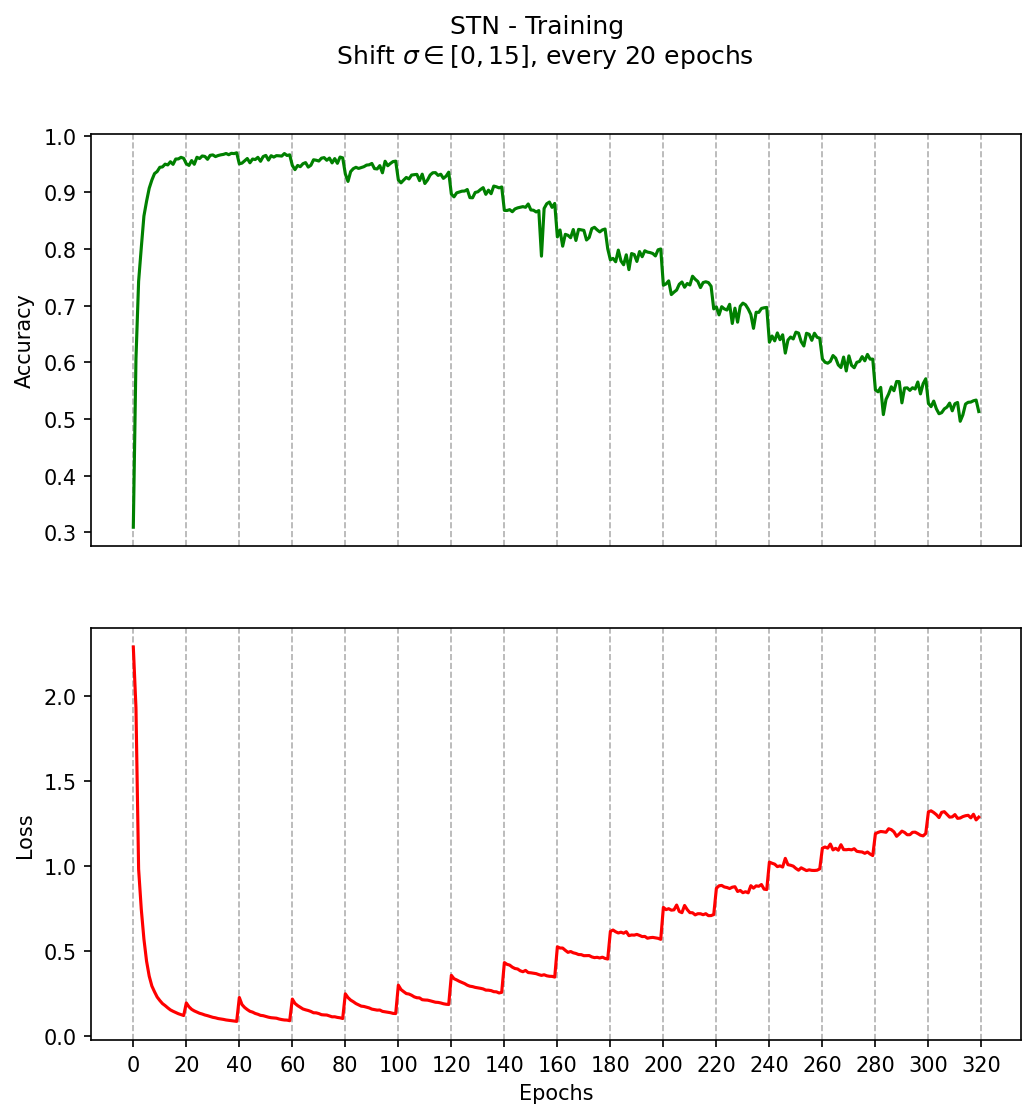

In [75]:
fig, ax = plt.subplots(2, 1, dpi=150, figsize=(8, 8))
ax[0].plot(acc_vals, 'g')
ax[1].plot(loss_vals, 'r')

for i in range(2):
    ax[i].set_xticks([e for e in range(0, 340, 20)])

ax[0].tick_params(axis='x',  which='both',  bottom=False,
                  top=False, labelbottom=False)
    
ax[0].set_ylabel("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")


for i in range(2):
    ax[i].grid(axis='x', linestyle='--')
fig.suptitle("STN - Training \n Shift $\sigma \in [0,15]$, every 20 epochs")
#fig.savefig('../figures/loss_acc_training_stn_28x28.png')

# Accuracy map

## Generating and saving the accuracy map

In [32]:
accuracy_map = np.zeros((55, 55))
for i in range(-27,28):
    for j in range(-27,28):
        transform=transforms.Compose([
                               WhatShift(args, i_offset=i, j_offset=j),
                               WhatBackground(contrast = args.contrast,
                                              noise=args.noise, 
                                              sf_0=args.sf_0, 
                                              B_sf=args.B_sf),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           ])
        test_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)
        accuracy = test(test_loader)
        accuracy_map[i + 27, j + 27] = accuracy 
        print(i, j, accuracy)


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -26 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -25 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -24 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -23 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -22 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -21 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -20 0.1135

Test set: Average loss: 0.0230, Accuracy: 1138/10000 (11%)

-27 -19 0.1138

Test set: Average loss: 0.0230, Accuracy: 1138/10000 (11%)

-27 -18 0.1138

Test set: Average loss: 0.0230, Accuracy: 1145/10000 (11%)

-27 -17 0.1145

Test set: Average loss: 0.0230, Accuracy: 1144/10000 (11%)

-27 -16 0.1144

Test set: Average loss: 0.0230, Accuracy: 1153/10000 (12%)

-27 -15 0.1153

Test set: A


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-25 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-25 -26 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-25 -25 0.1135

Test set: Average loss: 0.0230, Accuracy: 1136/10000 (11%)

-25 -24 0.1136

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-25 -23 0.1135

Test set: Average loss: 0.0230, Accuracy: 1137/10000 (11%)

-25 -22 0.1137

Test set: Average loss: 0.0230, Accuracy: 1140/10000 (11%)

-25 -21 0.114

Test set: Average loss: 0.0230, Accuracy: 1154/10000 (12%)

-25 -20 0.1154

Test set: Average loss: 0.0230, Accuracy: 1161/10000 (12%)

-25 -19 0.1161

Test set: Average loss: 0.0230, Accuracy: 1186/10000 (12%)

-25 -18 0.1186

Test set: Average loss: 0.0230, Accuracy: 1238/10000 (12%)

-25 -17 0.1238

Test set: Average loss: 0.0230, Accuracy: 1275/10000 (13%)

-25 -16 0.1275

Test set: Average loss: 0.0229, Accuracy: 1314/10000 (13%)

-25 -15 0.1314

Test set: Av


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-23 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-23 -26 0.1135

Test set: Average loss: 0.0230, Accuracy: 1138/10000 (11%)

-23 -25 0.1138

Test set: Average loss: 0.0230, Accuracy: 1136/10000 (11%)

-23 -24 0.1136

Test set: Average loss: 0.0230, Accuracy: 1139/10000 (11%)

-23 -23 0.1139

Test set: Average loss: 0.0230, Accuracy: 1145/10000 (11%)

-23 -22 0.1145

Test set: Average loss: 0.0230, Accuracy: 1154/10000 (12%)

-23 -21 0.1154

Test set: Average loss: 0.0231, Accuracy: 1176/10000 (12%)

-23 -20 0.1176

Test set: Average loss: 0.0231, Accuracy: 1206/10000 (12%)

-23 -19 0.1206

Test set: Average loss: 0.0231, Accuracy: 1204/10000 (12%)

-23 -18 0.1204

Test set: Average loss: 0.0231, Accuracy: 1262/10000 (13%)

-23 -17 0.1262

Test set: Average loss: 0.0232, Accuracy: 1215/10000 (12%)

-23 -16 0.1215

Test set: Average loss: 0.0232, Accuracy: 1169/10000 (12%)

-23 -15 0.1169

Test set: A


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-21 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-21 -26 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-21 -25 0.1135

Test set: Average loss: 0.0231, Accuracy: 1137/10000 (11%)

-21 -24 0.1137

Test set: Average loss: 0.0231, Accuracy: 1136/10000 (11%)

-21 -23 0.1136

Test set: Average loss: 0.0231, Accuracy: 1148/10000 (11%)

-21 -22 0.1148

Test set: Average loss: 0.0232, Accuracy: 1164/10000 (12%)

-21 -21 0.1164

Test set: Average loss: 0.0232, Accuracy: 1194/10000 (12%)

-21 -20 0.1194

Test set: Average loss: 0.0234, Accuracy: 1223/10000 (12%)

-21 -19 0.1223

Test set: Average loss: 0.0235, Accuracy: 1315/10000 (13%)

-21 -18 0.1315

Test set: Average loss: 0.0235, Accuracy: 1370/10000 (14%)

-21 -17 0.137

Test set: Average loss: 0.0235, Accuracy: 1337/10000 (13%)

-21 -16 0.1337

Test set: Average loss: 0.0234, Accuracy: 1337/10000 (13%)

-21 -15 0.1337

Test set: Av


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-19 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1134/10000 (11%)

-19 -26 0.1134

Test set: Average loss: 0.0231, Accuracy: 1137/10000 (11%)

-19 -25 0.1137

Test set: Average loss: 0.0231, Accuracy: 1138/10000 (11%)

-19 -24 0.1138

Test set: Average loss: 0.0231, Accuracy: 1143/10000 (11%)

-19 -23 0.1143

Test set: Average loss: 0.0232, Accuracy: 1182/10000 (12%)

-19 -22 0.1182

Test set: Average loss: 0.0234, Accuracy: 1197/10000 (12%)

-19 -21 0.1197

Test set: Average loss: 0.0235, Accuracy: 1276/10000 (13%)

-19 -20 0.1276

Test set: Average loss: 0.0236, Accuracy: 1300/10000 (13%)

-19 -19 0.13

Test set: Average loss: 0.0236, Accuracy: 1471/10000 (15%)

-19 -18 0.1471

Test set: Average loss: 0.0236, Accuracy: 1539/10000 (15%)

-19 -17 0.1539

Test set: Average loss: 0.0234, Accuracy: 1589/10000 (16%)

-19 -16 0.1589

Test set: Average loss: 0.0232, Accuracy: 1631/10000 (16%)

-19 -15 0.1631

Test set: Ave


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-17 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1136/10000 (11%)

-17 -26 0.1136

Test set: Average loss: 0.0231, Accuracy: 1138/10000 (11%)

-17 -25 0.1138

Test set: Average loss: 0.0231, Accuracy: 1144/10000 (11%)

-17 -24 0.1144

Test set: Average loss: 0.0233, Accuracy: 1177/10000 (12%)

-17 -23 0.1177

Test set: Average loss: 0.0234, Accuracy: 1196/10000 (12%)

-17 -22 0.1196

Test set: Average loss: 0.0235, Accuracy: 1292/10000 (13%)

-17 -21 0.1292

Test set: Average loss: 0.0236, Accuracy: 1370/10000 (14%)

-17 -20 0.137

Test set: Average loss: 0.0236, Accuracy: 1499/10000 (15%)

-17 -19 0.1499

Test set: Average loss: 0.0236, Accuracy: 1685/10000 (17%)

-17 -18 0.1685

Test set: Average loss: 0.0236, Accuracy: 1867/10000 (19%)

-17 -17 0.1867

Test set: Average loss: 0.0235, Accuracy: 1817/10000 (18%)

-17 -16 0.1817

Test set: Average loss: 0.0231, Accuracy: 1649/10000 (16%)

-17 -15 0.1649

Test set: Av


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-15 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-15 -26 0.1135

Test set: Average loss: 0.0231, Accuracy: 1143/10000 (11%)

-15 -25 0.1143

Test set: Average loss: 0.0232, Accuracy: 1170/10000 (12%)

-15 -24 0.117

Test set: Average loss: 0.0233, Accuracy: 1185/10000 (12%)

-15 -23 0.1185

Test set: Average loss: 0.0234, Accuracy: 1246/10000 (12%)

-15 -22 0.1246

Test set: Average loss: 0.0235, Accuracy: 1354/10000 (14%)

-15 -21 0.1354

Test set: Average loss: 0.0235, Accuracy: 1481/10000 (15%)

-15 -20 0.1481

Test set: Average loss: 0.0235, Accuracy: 1700/10000 (17%)

-15 -19 0.17

Test set: Average loss: 0.0236, Accuracy: 1884/10000 (19%)

-15 -18 0.1884

Test set: Average loss: 0.0236, Accuracy: 1956/10000 (20%)

-15 -17 0.1956

Test set: Average loss: 0.0231, Accuracy: 1833/10000 (18%)

-15 -16 0.1833

Test set: Average loss: 0.0222, Accuracy: 1827/10000 (18%)

-15 -15 0.1827

Test set: Aver


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-13 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1136/10000 (11%)

-13 -26 0.1136

Test set: Average loss: 0.0231, Accuracy: 1140/10000 (11%)

-13 -25 0.114

Test set: Average loss: 0.0232, Accuracy: 1159/10000 (12%)

-13 -24 0.1159

Test set: Average loss: 0.0233, Accuracy: 1188/10000 (12%)

-13 -23 0.1188

Test set: Average loss: 0.0234, Accuracy: 1266/10000 (13%)

-13 -22 0.1266

Test set: Average loss: 0.0234, Accuracy: 1415/10000 (14%)

-13 -21 0.1415

Test set: Average loss: 0.0234, Accuracy: 1617/10000 (16%)

-13 -20 0.1617

Test set: Average loss: 0.0233, Accuracy: 1851/10000 (19%)

-13 -19 0.1851

Test set: Average loss: 0.0231, Accuracy: 2033/10000 (20%)

-13 -18 0.2033

Test set: Average loss: 0.0227, Accuracy: 2002/10000 (20%)

-13 -17 0.2002

Test set: Average loss: 0.0216, Accuracy: 1962/10000 (20%)

-13 -16 0.1962

Test set: Average loss: 0.0205, Accuracy: 2321/10000 (23%)

-13 -15 0.2321

Test set: Av


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-11 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1134/10000 (11%)

-11 -26 0.1134

Test set: Average loss: 0.0231, Accuracy: 1148/10000 (11%)

-11 -25 0.1148

Test set: Average loss: 0.0232, Accuracy: 1159/10000 (12%)

-11 -24 0.1159

Test set: Average loss: 0.0233, Accuracy: 1223/10000 (12%)

-11 -23 0.1223

Test set: Average loss: 0.0233, Accuracy: 1345/10000 (13%)

-11 -22 0.1345

Test set: Average loss: 0.0233, Accuracy: 1481/10000 (15%)

-11 -21 0.1481

Test set: Average loss: 0.0232, Accuracy: 1719/10000 (17%)

-11 -20 0.1719

Test set: Average loss: 0.0231, Accuracy: 1925/10000 (19%)

-11 -19 0.1925

Test set: Average loss: 0.0226, Accuracy: 1992/10000 (20%)

-11 -18 0.1992

Test set: Average loss: 0.0218, Accuracy: 2031/10000 (20%)

-11 -17 0.2031

Test set: Average loss: 0.0206, Accuracy: 2181/10000 (22%)

-11 -16 0.2181

Test set: Average loss: 0.0191, Accuracy: 2950/10000 (30%)

-11 -15 0.295

Test set: Av


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-9 -27 0.1135

Test set: Average loss: 0.0231, Accuracy: 1137/10000 (11%)

-9 -26 0.1137

Test set: Average loss: 0.0231, Accuracy: 1143/10000 (11%)

-9 -25 0.1143

Test set: Average loss: 0.0232, Accuracy: 1188/10000 (12%)

-9 -24 0.1188

Test set: Average loss: 0.0233, Accuracy: 1269/10000 (13%)

-9 -23 0.1269

Test set: Average loss: 0.0233, Accuracy: 1383/10000 (14%)

-9 -22 0.1383

Test set: Average loss: 0.0233, Accuracy: 1623/10000 (16%)

-9 -21 0.1623

Test set: Average loss: 0.0231, Accuracy: 1739/10000 (17%)

-9 -20 0.1739

Test set: Average loss: 0.0229, Accuracy: 1898/10000 (19%)

-9 -19 0.1898

Test set: Average loss: 0.0223, Accuracy: 1951/10000 (20%)

-9 -18 0.1951

Test set: Average loss: 0.0214, Accuracy: 2241/10000 (22%)

-9 -17 0.2241

Test set: Average loss: 0.0197, Accuracy: 2789/10000 (28%)

-9 -16 0.2789

Test set: Average loss: 0.0176, Accuracy: 3792/10000 (38%)

-9 -15 0.3792

Test set: Average loss: 


Test set: Average loss: 0.0231, Accuracy: 1136/10000 (11%)

-7 -26 0.1136

Test set: Average loss: 0.0231, Accuracy: 1154/10000 (12%)

-7 -25 0.1154

Test set: Average loss: 0.0232, Accuracy: 1204/10000 (12%)

-7 -24 0.1204

Test set: Average loss: 0.0233, Accuracy: 1268/10000 (13%)

-7 -23 0.1268

Test set: Average loss: 0.0233, Accuracy: 1420/10000 (14%)

-7 -22 0.142

Test set: Average loss: 0.0233, Accuracy: 1581/10000 (16%)

-7 -21 0.1581

Test set: Average loss: 0.0231, Accuracy: 1674/10000 (17%)

-7 -20 0.1674

Test set: Average loss: 0.0229, Accuracy: 1918/10000 (19%)

-7 -19 0.1918

Test set: Average loss: 0.0224, Accuracy: 2088/10000 (21%)

-7 -18 0.2088

Test set: Average loss: 0.0208, Accuracy: 2629/10000 (26%)

-7 -17 0.2629

Test set: Average loss: 0.0191, Accuracy: 3331/10000 (33%)

-7 -16 0.3331

Test set: Average loss: 0.0166, Accuracy: 4324/10000 (43%)

-7 -15 0.4324

Test set: Average loss: 0.0144, Accuracy: 5102/10000 (51%)

-7 -14 0.5102

Test set: Average loss: 0


Test set: Average loss: 0.0231, Accuracy: 1152/10000 (12%)

-5 -25 0.1152

Test set: Average loss: 0.0232, Accuracy: 1204/10000 (12%)

-5 -24 0.1204

Test set: Average loss: 0.0233, Accuracy: 1281/10000 (13%)

-5 -23 0.1281

Test set: Average loss: 0.0232, Accuracy: 1426/10000 (14%)

-5 -22 0.1426

Test set: Average loss: 0.0232, Accuracy: 1581/10000 (16%)

-5 -21 0.1581

Test set: Average loss: 0.0230, Accuracy: 1862/10000 (19%)

-5 -20 0.1862

Test set: Average loss: 0.0227, Accuracy: 2068/10000 (21%)

-5 -19 0.2068

Test set: Average loss: 0.0220, Accuracy: 2367/10000 (24%)

-5 -18 0.2367

Test set: Average loss: 0.0206, Accuracy: 2918/10000 (29%)

-5 -17 0.2918

Test set: Average loss: 0.0185, Accuracy: 3585/10000 (36%)

-5 -16 0.3585

Test set: Average loss: 0.0158, Accuracy: 4595/10000 (46%)

-5 -15 0.4595

Test set: Average loss: 0.0131, Accuracy: 5436/10000 (54%)

-5 -14 0.5436

Test set: Average loss: 0.0113, Accuracy: 6093/10000 (61%)

-5 -13 0.6093

Test set: Average loss: 


Test set: Average loss: 0.0232, Accuracy: 1206/10000 (12%)

-3 -24 0.1206

Test set: Average loss: 0.0233, Accuracy: 1277/10000 (13%)

-3 -23 0.1277

Test set: Average loss: 0.0232, Accuracy: 1470/10000 (15%)

-3 -22 0.147

Test set: Average loss: 0.0230, Accuracy: 1766/10000 (18%)

-3 -21 0.1766

Test set: Average loss: 0.0227, Accuracy: 1985/10000 (20%)

-3 -20 0.1985

Test set: Average loss: 0.0222, Accuracy: 2368/10000 (24%)

-3 -19 0.2368

Test set: Average loss: 0.0213, Accuracy: 2700/10000 (27%)

-3 -18 0.27

Test set: Average loss: 0.0198, Accuracy: 3154/10000 (32%)

-3 -17 0.3154

Test set: Average loss: 0.0177, Accuracy: 3849/10000 (38%)

-3 -16 0.3849

Test set: Average loss: 0.0150, Accuracy: 4768/10000 (48%)

-3 -15 0.4768

Test set: Average loss: 0.0126, Accuracy: 5580/10000 (56%)

-3 -14 0.558

Test set: Average loss: 0.0103, Accuracy: 6470/10000 (65%)

-3 -13 0.647

Test set: Average loss: 0.0086, Accuracy: 7144/10000 (71%)

-3 -12 0.7144

Test set: Average loss: 0.007


Test set: Average loss: 0.0233, Accuracy: 1318/10000 (13%)

-1 -23 0.1318

Test set: Average loss: 0.0232, Accuracy: 1496/10000 (15%)

-1 -22 0.1496

Test set: Average loss: 0.0229, Accuracy: 1835/10000 (18%)

-1 -21 0.1835

Test set: Average loss: 0.0226, Accuracy: 2113/10000 (21%)

-1 -20 0.2113

Test set: Average loss: 0.0219, Accuracy: 2393/10000 (24%)

-1 -19 0.2393

Test set: Average loss: 0.0209, Accuracy: 2902/10000 (29%)

-1 -18 0.2902

Test set: Average loss: 0.0191, Accuracy: 3479/10000 (35%)

-1 -17 0.3479

Test set: Average loss: 0.0168, Accuracy: 4189/10000 (42%)

-1 -16 0.4189

Test set: Average loss: 0.0140, Accuracy: 5269/10000 (53%)

-1 -15 0.5269

Test set: Average loss: 0.0117, Accuracy: 6074/10000 (61%)

-1 -14 0.6074

Test set: Average loss: 0.0095, Accuracy: 6766/10000 (68%)

-1 -13 0.6766

Test set: Average loss: 0.0078, Accuracy: 7466/10000 (75%)

-1 -12 0.7466

Test set: Average loss: 0.0064, Accuracy: 7992/10000 (80%)

-1 -11 0.7992

Test set: Average loss: 


Test set: Average loss: 0.0230, Accuracy: 1729/10000 (17%)

1 -21 0.1729

Test set: Average loss: 0.0227, Accuracy: 1983/10000 (20%)

1 -20 0.1983

Test set: Average loss: 0.0222, Accuracy: 2278/10000 (23%)

1 -19 0.2278

Test set: Average loss: 0.0211, Accuracy: 2693/10000 (27%)

1 -18 0.2693

Test set: Average loss: 0.0192, Accuracy: 3356/10000 (34%)

1 -17 0.3356

Test set: Average loss: 0.0167, Accuracy: 4216/10000 (42%)

1 -16 0.4216

Test set: Average loss: 0.0140, Accuracy: 5253/10000 (53%)

1 -15 0.5253

Test set: Average loss: 0.0118, Accuracy: 5942/10000 (59%)

1 -14 0.5942

Test set: Average loss: 0.0099, Accuracy: 6606/10000 (66%)

1 -13 0.6606

Test set: Average loss: 0.0082, Accuracy: 7315/10000 (73%)

1 -12 0.7315

Test set: Average loss: 0.0069, Accuracy: 7785/10000 (78%)

1 -11 0.7785

Test set: Average loss: 0.0054, Accuracy: 8290/10000 (83%)

1 -10 0.829

Test set: Average loss: 0.0045, Accuracy: 8601/10000 (86%)

1 -9 0.8601

Test set: Average loss: 0.0040, Accurac


Test set: Average loss: 0.0217, Accuracy: 2416/10000 (24%)

3 -18 0.2416

Test set: Average loss: 0.0201, Accuracy: 3014/10000 (30%)

3 -17 0.3014

Test set: Average loss: 0.0178, Accuracy: 3761/10000 (38%)

3 -16 0.3761

Test set: Average loss: 0.0153, Accuracy: 4570/10000 (46%)

3 -15 0.457

Test set: Average loss: 0.0130, Accuracy: 5496/10000 (55%)

3 -14 0.5496

Test set: Average loss: 0.0112, Accuracy: 6152/10000 (62%)

3 -13 0.6152

Test set: Average loss: 0.0092, Accuracy: 6945/10000 (69%)

3 -12 0.6945

Test set: Average loss: 0.0076, Accuracy: 7546/10000 (75%)

3 -11 0.7546

Test set: Average loss: 0.0062, Accuracy: 8024/10000 (80%)

3 -10 0.8024

Test set: Average loss: 0.0055, Accuracy: 8337/10000 (83%)

3 -9 0.8337

Test set: Average loss: 0.0047, Accuracy: 8525/10000 (85%)

3 -8 0.8525

Test set: Average loss: 0.0042, Accuracy: 8693/10000 (87%)

3 -7 0.8693

Test set: Average loss: 0.0037, Accuracy: 8876/10000 (89%)

3 -6 0.8876

Test set: Average loss: 0.0038, Accuracy: 


Test set: Average loss: 0.0167, Accuracy: 4245/10000 (42%)

5 -15 0.4245

Test set: Average loss: 0.0141, Accuracy: 5244/10000 (52%)

5 -14 0.5244

Test set: Average loss: 0.0119, Accuracy: 5999/10000 (60%)

5 -13 0.5999

Test set: Average loss: 0.0100, Accuracy: 6737/10000 (67%)

5 -12 0.6737

Test set: Average loss: 0.0084, Accuracy: 7283/10000 (73%)

5 -11 0.7283

Test set: Average loss: 0.0075, Accuracy: 7632/10000 (76%)

5 -10 0.7632

Test set: Average loss: 0.0066, Accuracy: 7934/10000 (79%)

5 -9 0.7934

Test set: Average loss: 0.0058, Accuracy: 8227/10000 (82%)

5 -8 0.8227

Test set: Average loss: 0.0052, Accuracy: 8461/10000 (85%)

5 -7 0.8461

Test set: Average loss: 0.0049, Accuracy: 8519/10000 (85%)

5 -6 0.8519

Test set: Average loss: 0.0047, Accuracy: 8608/10000 (86%)

5 -5 0.8608

Test set: Average loss: 0.0044, Accuracy: 8678/10000 (87%)

5 -4 0.8678

Test set: Average loss: 0.0040, Accuracy: 8821/10000 (88%)

5 -3 0.8821

Test set: Average loss: 0.0036, Accuracy: 89


Test set: Average loss: 0.0113, Accuracy: 6270/10000 (63%)

7 -12 0.627

Test set: Average loss: 0.0101, Accuracy: 6703/10000 (67%)

7 -11 0.6703

Test set: Average loss: 0.0091, Accuracy: 7097/10000 (71%)

7 -10 0.7097

Test set: Average loss: 0.0085, Accuracy: 7330/10000 (73%)

7 -9 0.733

Test set: Average loss: 0.0075, Accuracy: 7666/10000 (77%)

7 -8 0.7666

Test set: Average loss: 0.0069, Accuracy: 7876/10000 (79%)

7 -7 0.7876

Test set: Average loss: 0.0064, Accuracy: 8060/10000 (81%)

7 -6 0.806

Test set: Average loss: 0.0060, Accuracy: 8154/10000 (82%)

7 -5 0.8154

Test set: Average loss: 0.0055, Accuracy: 8304/10000 (83%)

7 -4 0.8304

Test set: Average loss: 0.0051, Accuracy: 8479/10000 (85%)

7 -3 0.8479

Test set: Average loss: 0.0046, Accuracy: 8621/10000 (86%)

7 -2 0.8621

Test set: Average loss: 0.0044, Accuracy: 8659/10000 (87%)

7 -1 0.8659

Test set: Average loss: 0.0042, Accuracy: 8766/10000 (88%)

7 0 0.8766

Test set: Average loss: 0.0046, Accuracy: 8659/1000


Test set: Average loss: 0.0099, Accuracy: 6719/10000 (67%)

9 -9 0.6719

Test set: Average loss: 0.0089, Accuracy: 7052/10000 (71%)

9 -8 0.7052

Test set: Average loss: 0.0081, Accuracy: 7392/10000 (74%)

9 -7 0.7392

Test set: Average loss: 0.0076, Accuracy: 7559/10000 (76%)

9 -6 0.7559

Test set: Average loss: 0.0069, Accuracy: 7857/10000 (79%)

9 -5 0.7857

Test set: Average loss: 0.0065, Accuracy: 7910/10000 (79%)

9 -4 0.791

Test set: Average loss: 0.0061, Accuracy: 8035/10000 (80%)

9 -3 0.8035

Test set: Average loss: 0.0055, Accuracy: 8263/10000 (83%)

9 -2 0.8263

Test set: Average loss: 0.0053, Accuracy: 8337/10000 (83%)

9 -1 0.8337

Test set: Average loss: 0.0055, Accuracy: 8355/10000 (84%)

9 0 0.8355

Test set: Average loss: 0.0055, Accuracy: 8334/10000 (83%)

9 1 0.8334

Test set: Average loss: 0.0054, Accuracy: 8377/10000 (84%)

9 2 0.8377

Test set: Average loss: 0.0053, Accuracy: 8322/10000 (83%)

9 3 0.8322

Test set: Average loss: 0.0057, Accuracy: 8169/10000 (8


Test set: Average loss: 0.0092, Accuracy: 6893/10000 (69%)

11 -7 0.6893

Test set: Average loss: 0.0087, Accuracy: 7085/10000 (71%)

11 -6 0.7085

Test set: Average loss: 0.0080, Accuracy: 7297/10000 (73%)

11 -5 0.7297

Test set: Average loss: 0.0078, Accuracy: 7451/10000 (75%)

11 -4 0.7451

Test set: Average loss: 0.0073, Accuracy: 7559/10000 (76%)

11 -3 0.7559

Test set: Average loss: 0.0073, Accuracy: 7592/10000 (76%)

11 -2 0.7592

Test set: Average loss: 0.0073, Accuracy: 7586/10000 (76%)

11 -1 0.7586

Test set: Average loss: 0.0069, Accuracy: 7759/10000 (78%)

11 0 0.7759

Test set: Average loss: 0.0067, Accuracy: 7784/10000 (78%)

11 1 0.7784

Test set: Average loss: 0.0070, Accuracy: 7726/10000 (77%)

11 2 0.7726

Test set: Average loss: 0.0073, Accuracy: 7556/10000 (76%)

11 3 0.7556

Test set: Average loss: 0.0078, Accuracy: 7325/10000 (73%)

11 4 0.7325

Test set: Average loss: 0.0085, Accuracy: 7096/10000 (71%)

11 5 0.7096

Test set: Average loss: 0.0093, Accuracy: 6


Test set: Average loss: 0.0109, Accuracy: 6259/10000 (63%)

13 -6 0.6259

Test set: Average loss: 0.0105, Accuracy: 6373/10000 (64%)

13 -5 0.6373

Test set: Average loss: 0.0102, Accuracy: 6519/10000 (65%)

13 -4 0.6519

Test set: Average loss: 0.0099, Accuracy: 6608/10000 (66%)

13 -3 0.6608

Test set: Average loss: 0.0099, Accuracy: 6583/10000 (66%)

13 -2 0.6583

Test set: Average loss: 0.0097, Accuracy: 6640/10000 (66%)

13 -1 0.664

Test set: Average loss: 0.0096, Accuracy: 6634/10000 (66%)

13 0 0.6634

Test set: Average loss: 0.0096, Accuracy: 6597/10000 (66%)

13 1 0.6597

Test set: Average loss: 0.0100, Accuracy: 6518/10000 (65%)

13 2 0.6518

Test set: Average loss: 0.0105, Accuracy: 6362/10000 (64%)

13 3 0.6362

Test set: Average loss: 0.0110, Accuracy: 6155/10000 (62%)

13 4 0.6155

Test set: Average loss: 0.0117, Accuracy: 5912/10000 (59%)

13 5 0.5912

Test set: Average loss: 0.0122, Accuracy: 5699/10000 (57%)

13 6 0.5699

Test set: Average loss: 0.0130, Accuracy: 523


Test set: Average loss: 0.0141, Accuracy: 4854/10000 (49%)

15 -5 0.4854

Test set: Average loss: 0.0139, Accuracy: 4941/10000 (49%)

15 -4 0.4941

Test set: Average loss: 0.0140, Accuracy: 4945/10000 (49%)

15 -3 0.4945

Test set: Average loss: 0.0136, Accuracy: 5060/10000 (51%)

15 -2 0.506

Test set: Average loss: 0.0131, Accuracy: 5209/10000 (52%)

15 -1 0.5209

Test set: Average loss: 0.0130, Accuracy: 5307/10000 (53%)

15 0 0.5307

Test set: Average loss: 0.0131, Accuracy: 5377/10000 (54%)

15 1 0.5377

Test set: Average loss: 0.0135, Accuracy: 5165/10000 (52%)

15 2 0.5165

Test set: Average loss: 0.0139, Accuracy: 5041/10000 (50%)

15 3 0.5041

Test set: Average loss: 0.0141, Accuracy: 4907/10000 (49%)

15 4 0.4907

Test set: Average loss: 0.0144, Accuracy: 4884/10000 (49%)

15 5 0.4884

Test set: Average loss: 0.0149, Accuracy: 4594/10000 (46%)

15 6 0.4594

Test set: Average loss: 0.0156, Accuracy: 4334/10000 (43%)

15 7 0.4334

Test set: Average loss: 0.0166, Accuracy: 3897


Test set: Average loss: 0.0173, Accuracy: 3504/10000 (35%)

17 -4 0.3504

Test set: Average loss: 0.0173, Accuracy: 3582/10000 (36%)

17 -3 0.3582

Test set: Average loss: 0.0170, Accuracy: 3563/10000 (36%)

17 -2 0.3563

Test set: Average loss: 0.0168, Accuracy: 3704/10000 (37%)

17 -1 0.3704

Test set: Average loss: 0.0168, Accuracy: 3686/10000 (37%)

17 0 0.3686

Test set: Average loss: 0.0169, Accuracy: 3732/10000 (37%)

17 1 0.3732

Test set: Average loss: 0.0171, Accuracy: 3744/10000 (37%)

17 2 0.3744

Test set: Average loss: 0.0174, Accuracy: 3697/10000 (37%)

17 3 0.3697

Test set: Average loss: 0.0176, Accuracy: 3617/10000 (36%)

17 4 0.3617

Test set: Average loss: 0.0180, Accuracy: 3392/10000 (34%)

17 5 0.3392

Test set: Average loss: 0.0185, Accuracy: 3207/10000 (32%)

17 6 0.3207

Test set: Average loss: 0.0189, Accuracy: 2886/10000 (29%)

17 7 0.2886

Test set: Average loss: 0.0195, Accuracy: 2627/10000 (26%)

17 8 0.2627

Test set: Average loss: 0.0200, Accuracy: 2300


Test set: Average loss: 0.0197, Accuracy: 2548/10000 (25%)

19 -3 0.2548

Test set: Average loss: 0.0197, Accuracy: 2554/10000 (26%)

19 -2 0.2554

Test set: Average loss: 0.0195, Accuracy: 2625/10000 (26%)

19 -1 0.2625

Test set: Average loss: 0.0197, Accuracy: 2589/10000 (26%)

19 0 0.2589

Test set: Average loss: 0.0199, Accuracy: 2515/10000 (25%)

19 1 0.2515

Test set: Average loss: 0.0200, Accuracy: 2624/10000 (26%)

19 2 0.2624

Test set: Average loss: 0.0202, Accuracy: 2502/10000 (25%)

19 3 0.2502

Test set: Average loss: 0.0205, Accuracy: 2434/10000 (24%)

19 4 0.2434

Test set: Average loss: 0.0206, Accuracy: 2317/10000 (23%)

19 5 0.2317

Test set: Average loss: 0.0208, Accuracy: 2163/10000 (22%)

19 6 0.2163

Test set: Average loss: 0.0211, Accuracy: 1969/10000 (20%)

19 7 0.1969

Test set: Average loss: 0.0214, Accuracy: 1856/10000 (19%)

19 8 0.1856

Test set: Average loss: 0.0216, Accuracy: 1646/10000 (16%)

19 9 0.1646

Test set: Average loss: 0.0218, Accuracy: 1632/


Test set: Average loss: 0.0219, Accuracy: 1367/10000 (14%)

21 -2 0.1367

Test set: Average loss: 0.0219, Accuracy: 1429/10000 (14%)

21 -1 0.1429

Test set: Average loss: 0.0219, Accuracy: 1462/10000 (15%)

21 0 0.1462

Test set: Average loss: 0.0218, Accuracy: 1407/10000 (14%)

21 1 0.1407

Test set: Average loss: 0.0219, Accuracy: 1460/10000 (15%)

21 2 0.146

Test set: Average loss: 0.0221, Accuracy: 1357/10000 (14%)

21 3 0.1357

Test set: Average loss: 0.0223, Accuracy: 1346/10000 (13%)

21 4 0.1346

Test set: Average loss: 0.0225, Accuracy: 1216/10000 (12%)

21 5 0.1216

Test set: Average loss: 0.0227, Accuracy: 1104/10000 (11%)

21 6 0.1104

Test set: Average loss: 0.0228, Accuracy: 1149/10000 (11%)

21 7 0.1149

Test set: Average loss: 0.0229, Accuracy: 1027/10000 (10%)

21 8 0.1027

Test set: Average loss: 0.0230, Accuracy: 989/10000 (10%)

21 9 0.0989

Test set: Average loss: 0.0230, Accuracy: 1057/10000 (11%)

21 10 0.1057

Test set: Average loss: 0.0231, Accuracy: 1045/10


Test set: Average loss: 0.0233, Accuracy: 820/10000 (8%)

23 0 0.082

Test set: Average loss: 0.0233, Accuracy: 839/10000 (8%)

23 1 0.0839

Test set: Average loss: 0.0234, Accuracy: 852/10000 (9%)

23 2 0.0852

Test set: Average loss: 0.0234, Accuracy: 823/10000 (8%)

23 3 0.0823

Test set: Average loss: 0.0235, Accuracy: 788/10000 (8%)

23 4 0.0788

Test set: Average loss: 0.0235, Accuracy: 770/10000 (8%)

23 5 0.077

Test set: Average loss: 0.0235, Accuracy: 765/10000 (8%)

23 6 0.0765

Test set: Average loss: 0.0236, Accuracy: 737/10000 (7%)

23 7 0.0737

Test set: Average loss: 0.0236, Accuracy: 750/10000 (8%)

23 8 0.075

Test set: Average loss: 0.0236, Accuracy: 773/10000 (8%)

23 9 0.0773

Test set: Average loss: 0.0236, Accuracy: 821/10000 (8%)

23 10 0.0821

Test set: Average loss: 0.0236, Accuracy: 855/10000 (9%)

23 11 0.0855

Test set: Average loss: 0.0235, Accuracy: 968/10000 (10%)

23 12 0.0968

Test set: Average loss: 0.0235, Accuracy: 1013/10000 (10%)

23 13 0.1013

T


Test set: Average loss: 0.0232, Accuracy: 1140/10000 (11%)

25 2 0.114

Test set: Average loss: 0.0232, Accuracy: 1143/10000 (11%)

25 3 0.1143

Test set: Average loss: 0.0232, Accuracy: 1140/10000 (11%)

25 4 0.114

Test set: Average loss: 0.0232, Accuracy: 1137/10000 (11%)

25 5 0.1137

Test set: Average loss: 0.0232, Accuracy: 1138/10000 (11%)

25 6 0.1138

Test set: Average loss: 0.0232, Accuracy: 1137/10000 (11%)

25 7 0.1137

Test set: Average loss: 0.0232, Accuracy: 1136/10000 (11%)

25 8 0.1136

Test set: Average loss: 0.0232, Accuracy: 1136/10000 (11%)

25 9 0.1136

Test set: Average loss: 0.0232, Accuracy: 1133/10000 (11%)

25 10 0.1133

Test set: Average loss: 0.0232, Accuracy: 1137/10000 (11%)

25 11 0.1137

Test set: Average loss: 0.0232, Accuracy: 1138/10000 (11%)

25 12 0.1138

Test set: Average loss: 0.0231, Accuracy: 1138/10000 (11%)

25 13 0.1138

Test set: Average loss: 0.0231, Accuracy: 1132/10000 (11%)

25 14 0.1132

Test set: Average loss: 0.0231, Accuracy: 1137/


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 3 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 4 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 5 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 6 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 7 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 8 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 9 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 10 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 11 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 12 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 13 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 14 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 15 0.1135

Test set: Average loss: 0.0230, Accuracy: 11

In [3]:
MAP_PATH = "../models/acc_map_stn_28x28.npy"

In [34]:
np.save(MAP_PATH, accuracy_map)

## Loading the map and visualisation

In [4]:
accuracy_map = np.load(MAP_PATH)

In [5]:
accuracy_map

array([[0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       ...,
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135]])

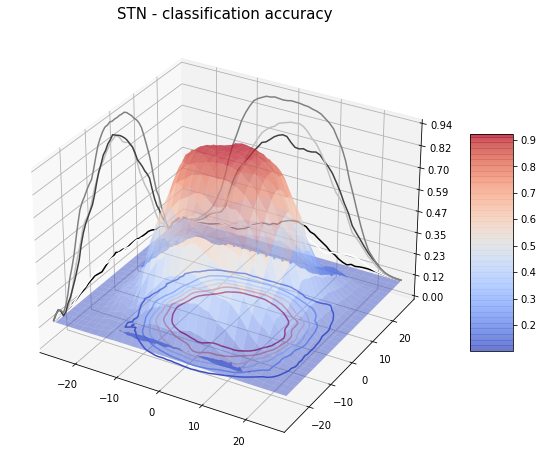

In [7]:
fig = plt.figure(figsize=(10,8))

for i in range(55):
    for j in range(55):
        accuracy_map[i,j] = max(accuracy_map[i,j], 0.1) # taking out values that are less than 10%

ax = fig.add_subplot(111, projection='3d')

# Creating a meshgrid of coordinates
X = np.arange(-27, 28)
Y = np.arange(-27, 28)
X, Y = np.meshgrid(X, Y) 

surf = ax.plot_surface(X, Y, accuracy_map, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True, alpha=0.5)

#ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contour(X, Y, accuracy_map, [0.2, 0.3, 0.4, 0.5, 0.6, 0.7], zdir='z', offset=0, cmap=cm.coolwarm, alpha = 1)
cset = ax.contour(X, Y, accuracy_map, [-20, -10, 0, 10, 20], zdir='x', offset=-27.5, cmap = 'gray')
cset = ax.contour(X, Y, accuracy_map,  [-20, -10, 0, 10, 20], zdir='y', offset=27.5, cmap = 'gray')


# Customize the z axis.
ax.set_xlim(-27.5, 27.5)
ax.set_zlim(-27.5, 27.5)
ax.set_zlim(0, 0.94)
ax.zaxis.set_major_locator(LinearLocator(9))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title('STN - classification accuracy', size=15)

# Add a color bar which maps values to colors.
cbar = fig.colorbar(surf, shrink=0.5, aspect=5, ticks=[0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9])
fig.savefig('../figures/stn_28x28_accuracy_map.png', bbox_inches='tight', pad_inches=0.1)